<a href="https://colab.research.google.com/github/SunhoPark2107/python-restore/blob/main/0705_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D_%2B_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
xy = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/data-02-stock_daily.csv', delimiter=",")

In [3]:
#train, test split
seq_length = 7
train_size = int(len(xy)*0.7)
train_set = xy[:train_size]
test_set = xy[train_size - seq_length:]
print(train_set.shape, test_set.shape)

(512, 5) (227, 5)


In [4]:
def minmax_scaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0)-np.min(data,0)
  return numerator / (denominator + 1e-7)

In [5]:
#scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [6]:
def build_dataset(time_series_data, seq_length):
  data_X = []; data_y = []
  for i in range(0, len(time_series_data)-seq_length):
    x_ = time_series_data[i: i + seq_length, :]
    y_ = time_series_data[i+seq_length, [-1]]
    data_X.append(x_); data_y.append(y_)
  return np.array(data_X), np.array(data_y)


In [7]:
train_X, train_y = build_dataset(train_set, seq_length)
test_X, test_y = build_dataset(test_set, seq_length)

In [8]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [9]:
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [10]:
train_X_tensor = torch.FloatTensor(train_X)
train_y_tensor = torch.FloatTensor(train_y)
test_X_tensor = torch.FloatTensor(test_X)
test_y_tensor = torch.FloatTensor(test_y)

In [11]:
class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()
    self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, 
                             batch_first=True)
    self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

net = Net(data_dim, hidden_dim, output_dim, 1)

In [12]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [13]:
# training!
for i in range(iterations):
  optimizer.zero_grad()
  outputs = net(train_X_tensor)
  loss = criterion(outputs, train_y_tensor)
  loss.backward()
  optimizer.step()
  print(i, loss.item())

0 0.3816586434841156
1 0.2933013141155243
2 0.2232895940542221
3 0.16713787615299225
4 0.12248915433883667
5 0.0880480706691742
6 0.06338530033826828
7 0.04867362976074219
8 0.043964844197034836
9 0.047742124646902084
10 0.055655818432569504
11 0.06252619624137878
12 0.0654703676700592
13 0.0641372948884964
14 0.05958113446831703
15 0.05330348759889603
16 0.046701304614543915
17 0.040805768221616745
18 0.03620252013206482
19 0.03306516259908676
20 0.03125288337469101
21 0.03043215163052082
22 0.030192047357559204
23 0.0301357414573431
24 0.0299412552267313
25 0.029392128810286522
26 0.028384430333971977
27 0.026917090639472008
28 0.025072161108255386
29 0.022989261895418167
30 0.020837189629673958
31 0.01878475584089756
32 0.016972925513982773
33 0.015490898862481117
34 0.01435969676822424
35 0.013527119532227516
36 0.012877955101430416
37 0.012261230498552322
38 0.0115318289026618
39 0.010596764273941517
40 0.009449233300983906
41 0.00817281473428011
42 0.006910208147019148
43 0.00580

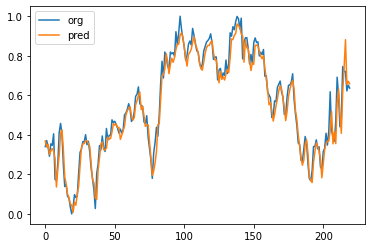

In [14]:
plt.plot(test_y)
plt.plot(net(test_X_tensor).data.numpy())
plt.legend(['org', 'pred'])
plt.show()

In [15]:
import tensorflow as tf
import keras

In [23]:
# 파이토치로 tensor 배열 만들어 가설(사용자 정의 식)에 적용하기.

x = torch.FloatTensor([-1.8, 0.6, 1.0])
w = torch.FloatTensor([2])
b = torch.FloatTensor([3])
z = w * x + b

print(x, w, b, z)

tensor([-1.8000,  0.6000,  1.0000]) tensor([2.]) tensor([3.]) tensor([-0.6000,  4.2000,  5.0000])


In [22]:
# Tensorflow로 tensor 배열 만들어 가설(사용자 정의 식)에 적용하기.
# tensorflow 1.0 스타일

# 그래프 설계 마침.(앞으로 무엇을 할 것이다 라는 것)
g = tf.Graph()
with g.as_default():
  x = tf.compat.v1.placeholder(dtype = tf.float32, shape = (None), name = "x")
  w = tf.Variable(2.0, name = "weight")
  b = tf.Variable(3.0, name = "bias")
  z = w * x + b
  init = tf.compat.v1.global_variables_initializer()

# 세션 만들기(실행 코드)
with tf.compat.v1.Session(graph=g) as sess:
  sess.run(init)
  for t in [-1.8, 0.6, 1.0]:
    print(t, sess.run(z, feed_dict = {x:t}))

-1.8 -0.5999999
0.6 4.2
1.0 5.0


In [24]:
# tensorflow 2 스타일

w = tf.Variable(2.0, name = "weight")
b = tf.Variable(3.0, name = "bias")

for x in [-1.8, 0.6, 1.0]:
  z = w * x + b
  print(x, z)

-1.8 tf.Tensor(-0.5999999, shape=(), dtype=float32)
0.6 tf.Tensor(4.2, shape=(), dtype=float32)
1.0 tf.Tensor(5.0, shape=(), dtype=float32)


In [25]:
# tensorflow2 극단적으로 간결화된 코드.

w = tf.Variable(2.0, name = "weight")
b = tf.Variable(3.0, name = "bias")

z = w * [-1.8, 0.6, 1.0] + b
print(z)

tf.Tensor([-0.5999999  4.2        5.       ], shape=(3,), dtype=float32)


In [34]:
class TfLinearRegressor():
  def __init__(self, learning_rate = 0.01):
    self.w = tf.Variable(tf.zeros(shape=(1)))
    self.b = tf.Variable(tf.zeros(shape=(1)))
    self.optimizer = tf.keras.optimizers.SGD(lr=learning_rate)

  def fit(self, X, y, num_epochs=10):
    costs = []
    for step in range(num_epochs):
      with tf.GradientTape() as tape:
        z_net = self.w*X+self.b
        z_net = tf.reshape(z_net, [-1])
        sqr_errors = tf.square(y-z_net)
        mean_cost = tf.reduce_mean(sqr_errors)
      
      grads = tape.gradient(mean_cost, [self.w, self.b])
      self.optimizer.apply_gradients(zip(grads, [self.w, self.b]))
      costs.append(mean_cost.numpy())
    return costs

  def predict(self, X):
    return self.w * X + self.b


In [35]:
lr_model = TfLinearRegressor()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
X_train = np.arange(10).reshape((10,1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

In [37]:
train_costs = lr_model.fit(X_train, y_train)

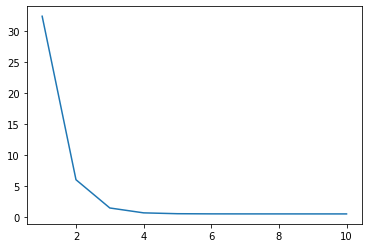

In [38]:
plt.plot(range(1, 11), train_costs)